In [1]:
import csv
import re

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from collections import defaultdict

In [4]:
ss_map = {'53': defaultdict(set), '35': defaultdict(set)}
ss_age = {'5': dict(), '3': dict()}

In [5]:
gene_gained = {
    '5': set(), 
    '3': set()
}

In [6]:
gene_ss = defaultdict(lambda: defaultdict(set))

In [7]:
with open("../data/ref/homo_sapiens/annot/out/meta_exon.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        _, gene_func, chrom, *_, strand, _, make_up = row

        if gene_func != "protein_coding":
            continue

        for exon in make_up.split(","):
            kind, *pos = re.split('[=-]', exon)

            beg, end = map(int, pos)
            beg -= 1

            if kind != "IE":
                continue

            ss5 = end if strand == "+" else beg
            ss3 = beg if strand == "+" else end

            strand = int(strand == "+")

            ss5 = f"{chrom}:{ss5}:{strand}"
            ss3 = f"{chrom}:{ss3}:{strand}"

            ss_map['53'][ss5].add(ss3)
            ss_map['35'][ss3].add(ss5)

In [8]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for row in reader:
        gene, meta_exon, p, ss, _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row
        
        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue
        
        if gain_ages == "homo_sapiens":
            age = 0
        else:
            age = float(gain_ages)
        
        ss_age[p][ss] = age
        
        gene_gained[p].add(gene)
        gene_ss[gene][p].add(ss)

In [9]:
gained_5a3 = gene_gained['5'] & gene_gained['3']
gained_5o3 = gene_gained['5'] | gene_gained['3']

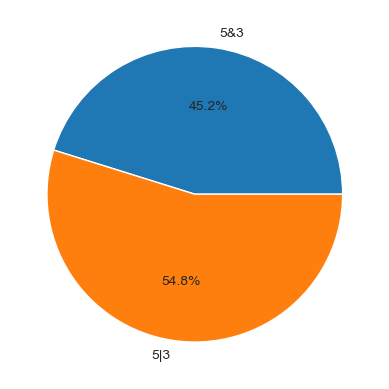

In [10]:
percent = len(gained_5a3) / len(gained_5o3) * 100

_ = plt.pie([percent, 100 - percent], labels=["5&3", "5|3"], autopct='%1.1f%%')
plt.savefig("figs/main2e_1.pdf")

In [11]:
gained_5a3pair = set()

In [12]:
cat_count = defaultdict(lambda: 0)
long_data = list()

In [13]:
for gene in gained_5a3:
    for ss5 in gene_ss[gene]['5']:
        age5 = ss_age['5'][ss5]
        
        for ss3 in ss_map['53'][ss5]:
            if ss3 not in gene_ss[gene]['3']:
                continue

            gained_5a3pair.add(gene)
            age3 = ss_age['3'][ss3]
            
            if age3 > age5:
                cat = "3 > 5"
            elif age5 > age3:
                cat = "5 > 3"
            else:
                cat = "5 = 3"
            
            cat_count[cat] += 1
            long_data.append({
                'age5': age5,
                'age3': age3,
                'cat':  cat
            })

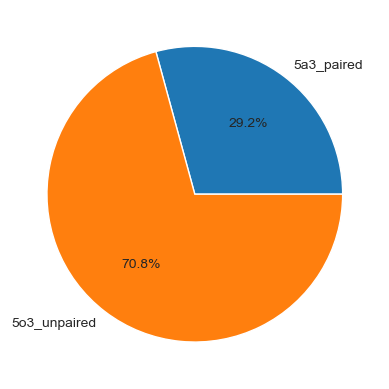

In [14]:
percent = len(gained_5a3pair) / len(gained_5a3) * 100

_ = plt.pie([percent, 100 - percent], labels=["5a3_paired", "5o3_unpaired"], autopct='%1.1f%%')
plt.savefig("figs/main2e_2.pdf")

In [15]:
t = sum(cat_count.values())

In [16]:
ps = []
cs = []

In [17]:
for cat in cat_count:
    ps.append(cat_count[cat] / t * 100)
    cs.append(cat)

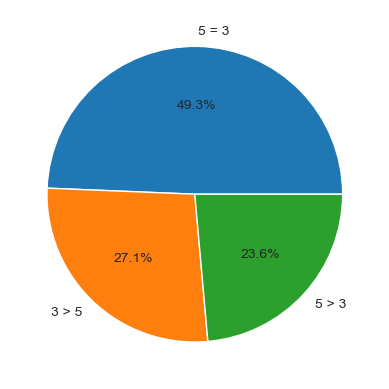

In [18]:
_ = plt.pie(ps, labels=cs, autopct='%1.1f%%')
plt.savefig("figs/main2f_2.pdf")

In [19]:
frame = pd.DataFrame(long_data)

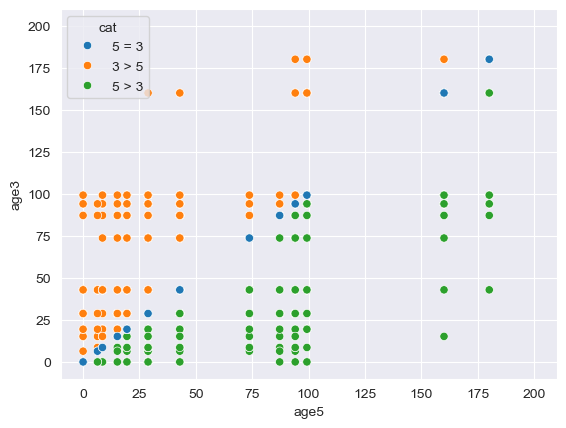

In [20]:
sns.scatterplot(frame, x='age5', y='age3', hue='cat')

_ = plt.xlim(-10, 210)
_ = plt.ylim(-10, 210)

plt.savefig("figs/main2f_1.pdf")